In [9]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging
import ipynb
import decimal

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

# importing my model functions for analysis
from psi_transmission.model_functions import *

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# some data loads to be performed right away
start_time_dict = get_start_times()
not_norm_data_dict = load_all_data(start_time_dict['edgard_p_beam'], norm_dict = None)
norm_dict = ucn_yield(not_norm_data_dict, plotting_flag = False);
main_data_dict = load_all_data(start_time_dict['edgard_p_beam'], norm_dict = norm_dict)

# Transmission

Transmission is calculated by comparing the counts from a run, in any guided configuration, to that of the guide-less configuration. Every run is normalized according to increasing losses within the source volume, attributed to $s_{D_2}$ frost build-up. Explicitly, transmission is calculated as

$$\large{T = \frac{N^\mathrm{guide}}{N^\mathrm{nom}}}$$

where $N^\mathrm{nom}$ is the number of counts in the nominal configuration, with no mounted guide. The value used is the average of all the runs carried out in the nominal configuration, after their normalization. There are four of these values, one for each of the run types: direct shot, 5, 20, and 100 second pre-storage times. 

In [32]:
run_type_list = ['shot', 's005', 's020', 's100']

# working with a copy to avoid any overwriting
all_data_dict = dict(main_data_dict)

# fig, ax = plt.subplots()
# ax = plt.gca()

N_nom_dict = {}

for run_type in run_type_list:
    
    # getting the nominal configuration data
    arr = all_data_dict['NOMI', run_type]
    
    print('Average normalized counts for ' \
          + run_type + \
          ' runs, in nominal config: {} +/- {}'.format(
                                        np.average(arr[:,2]), np.std(arr[:,2])))
    
    # save the counts and associated standard error to the dictionary
    N_nom_dict[run_type, 'N'] = np.average(arr[:,2])
    N_nom_dict[run_type, 'N_err'] =  np.std(arr[:,2])
    
    N_nom_err = (1 / np.shape(arr)[0]) * np.sqrt(np.sum(arr[:,3]**2))
    print(N_nom_err)
    

Average normalized counts for shot runs, in nominal config: 5835299.995361321 +/- 353541.3205821949
2498.539669312134
Average normalized counts for s005 runs, in nominal config: 122033.01401056456 +/- 3543.8681727606977
98.98483780566413
Average normalized counts for s020 runs, in nominal config: 64178.08167892729 +/- 2171.032599005793
75.304872720172
Average normalized counts for s100 runs, in nominal config: 5057.97448525639 +/- 233.45458358521344
11.25230051723961


Error in transmission is simply propagated as:

\begin{align} 
\frac{\delta T}{T} = \sqrt{\left (\frac{\delta N^\mathrm{guide}}{N^\mathrm{guide}} \right )^2 + \left (\frac{\delta N^\mathrm{nom}}{N^\mathrm{nom}} \right )^2}
\end{align}

The various runs carried out using the same configuration and pre-storage time, are averaged, and the error in the average is propagated as

\begin{align} 
\delta T_\mathrm{ave} = \frac{1}{N}\sqrt{\sum_{i=1}^N \left(\delta T_i\right)^2}
\end{align}

JPTI: 0.013243535812941019
JPSU: 0.016172920518996953
DISK: 0.007472076690914534
GD01: 0.02125159740896307
GD03: 0.01825231602984175
EPSU: 0.021893666018780712


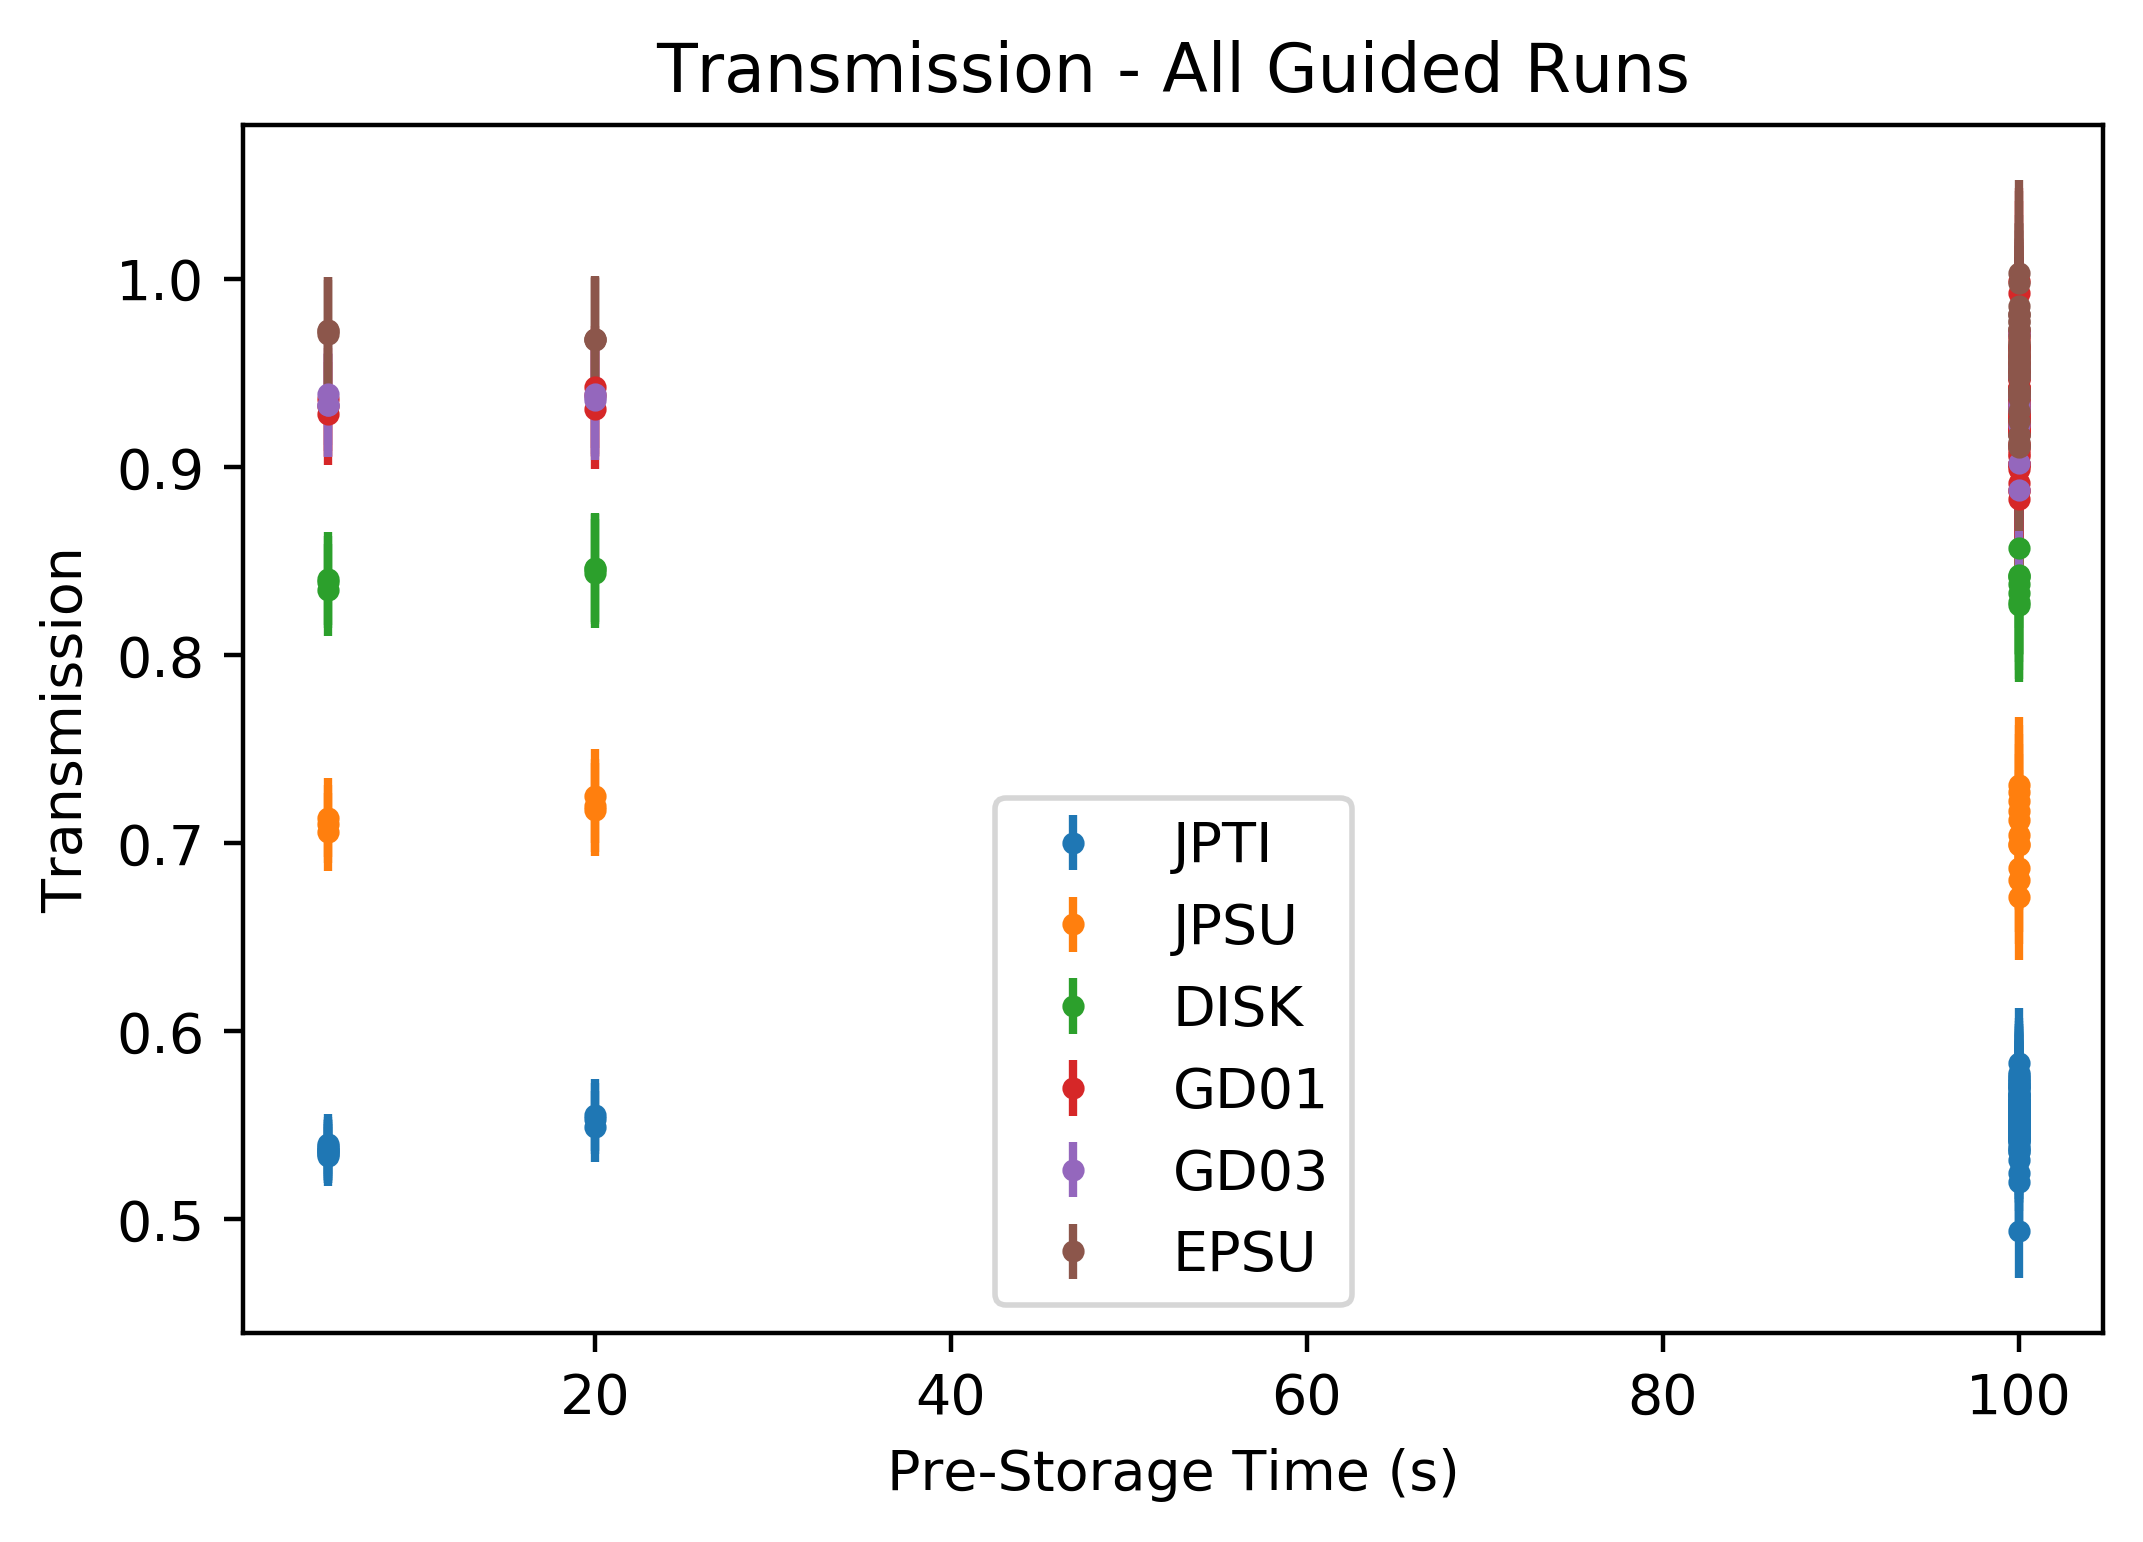

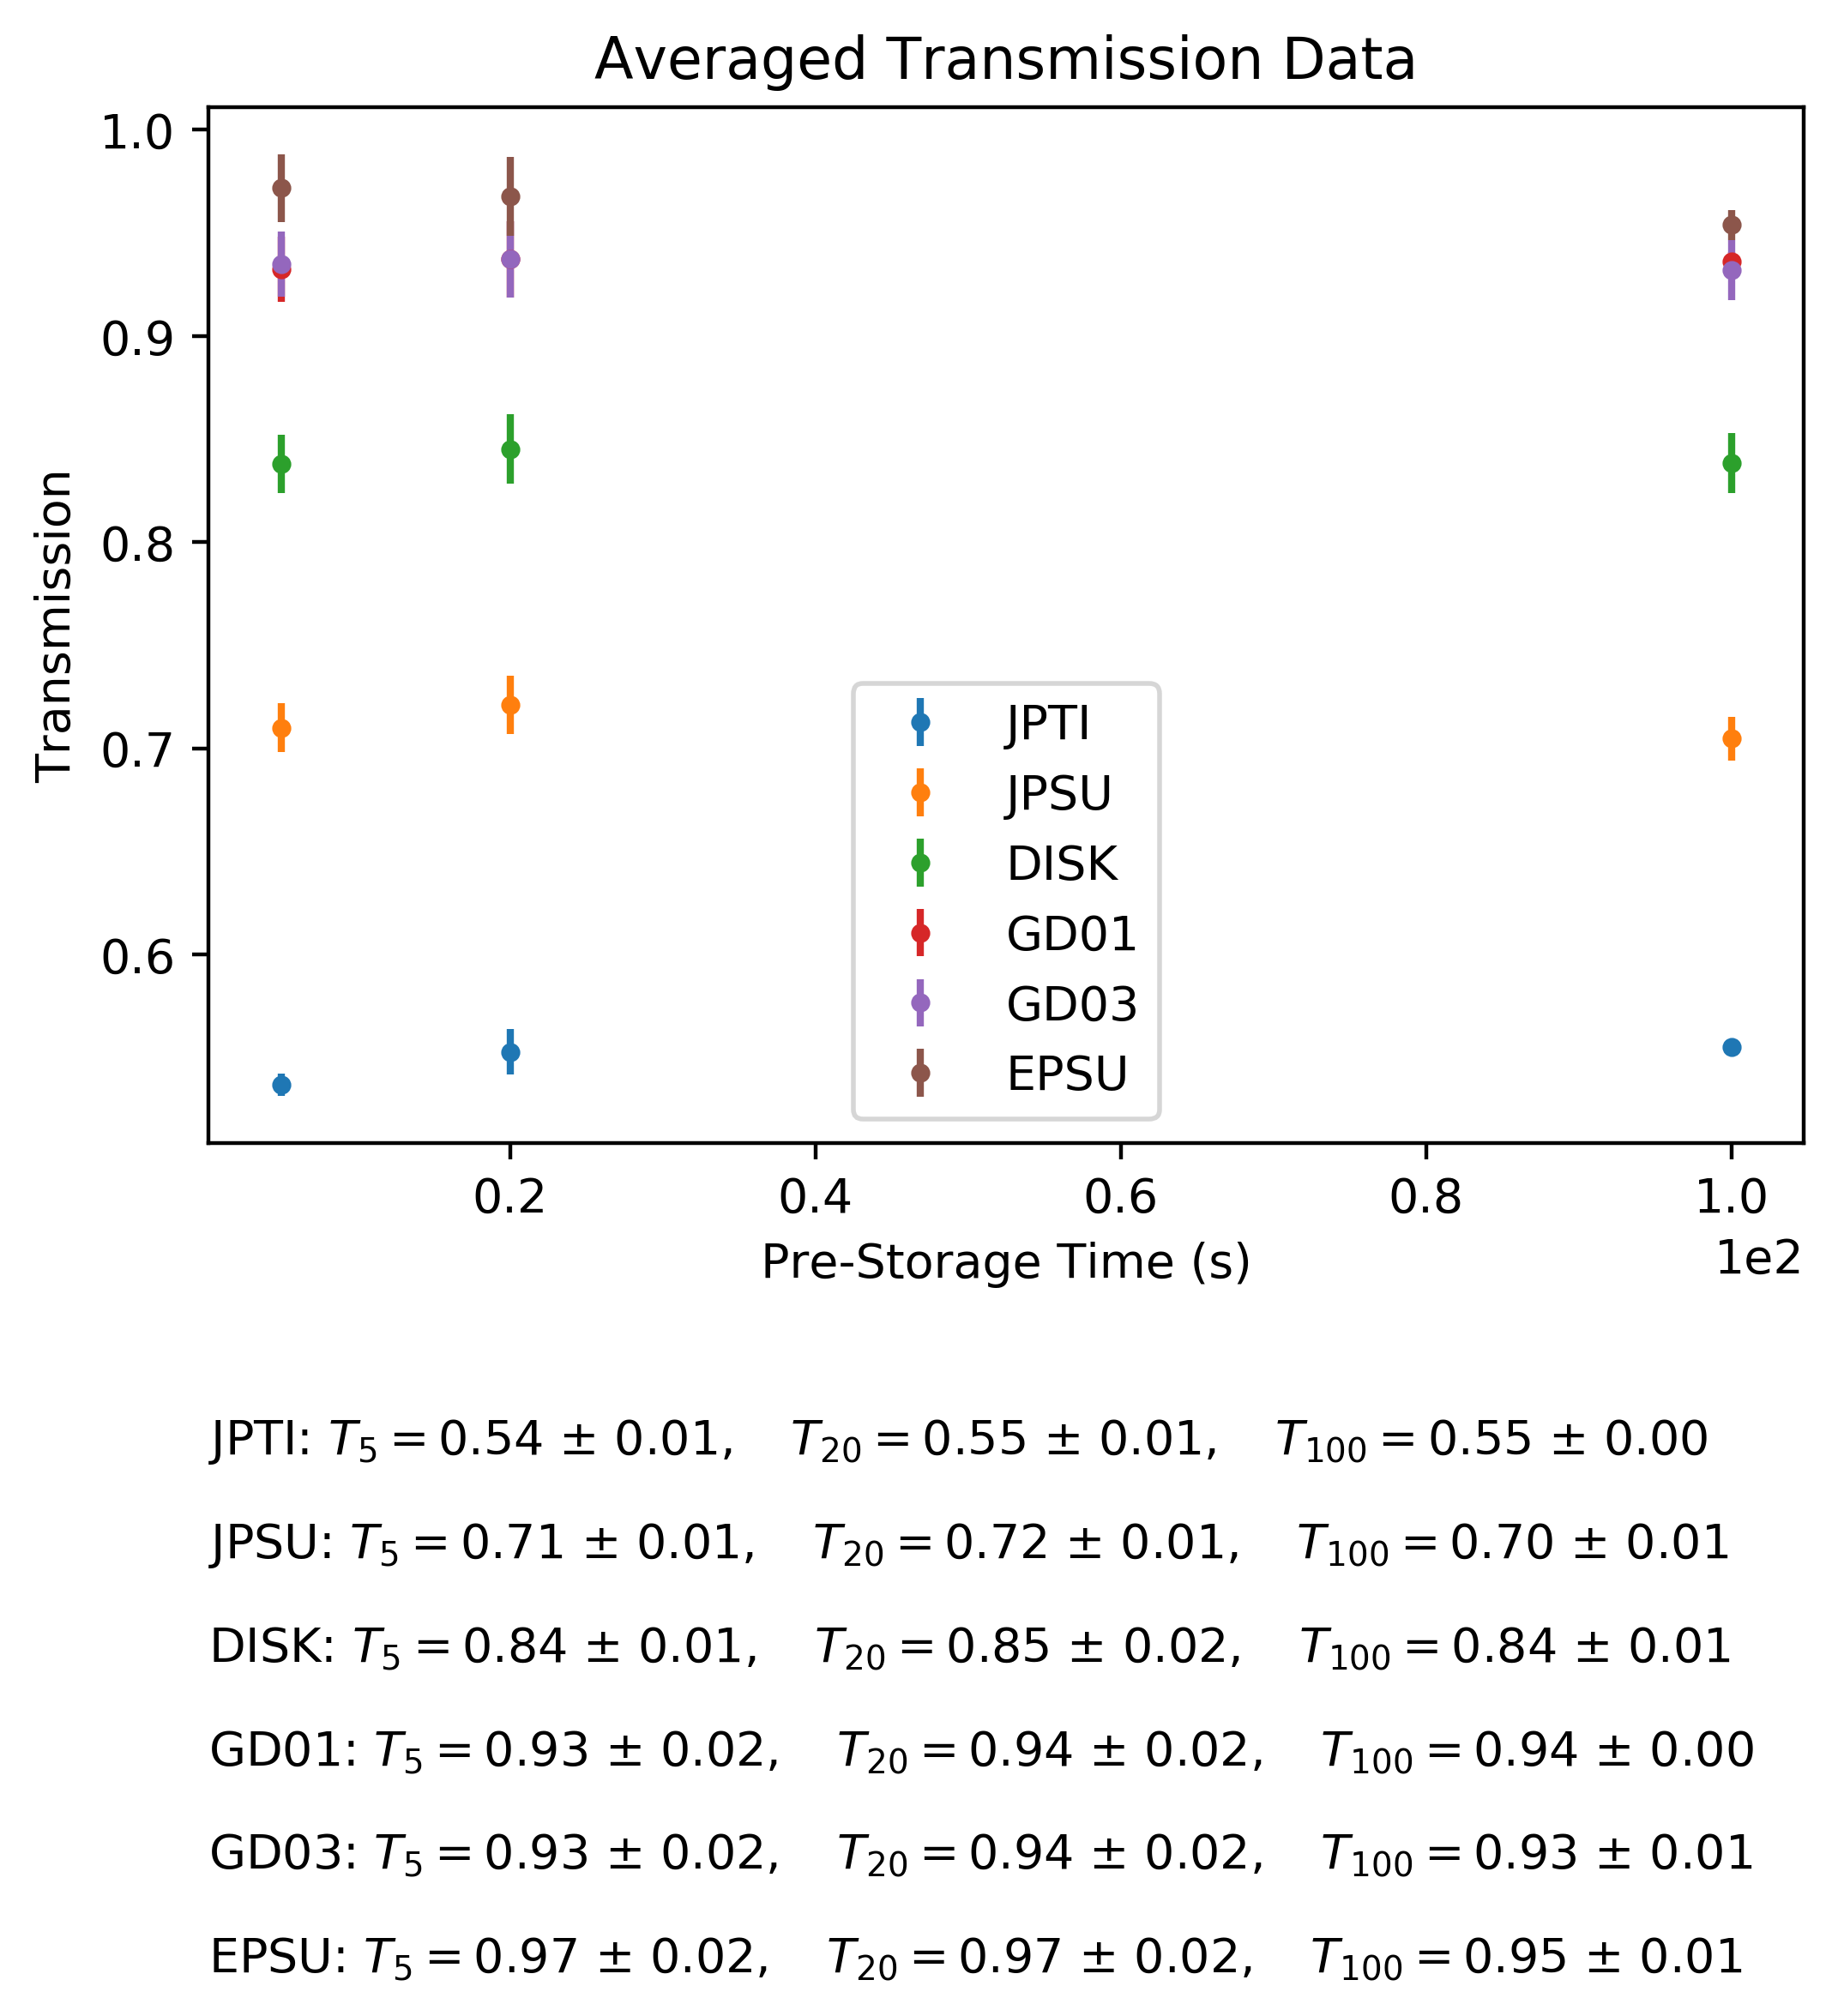

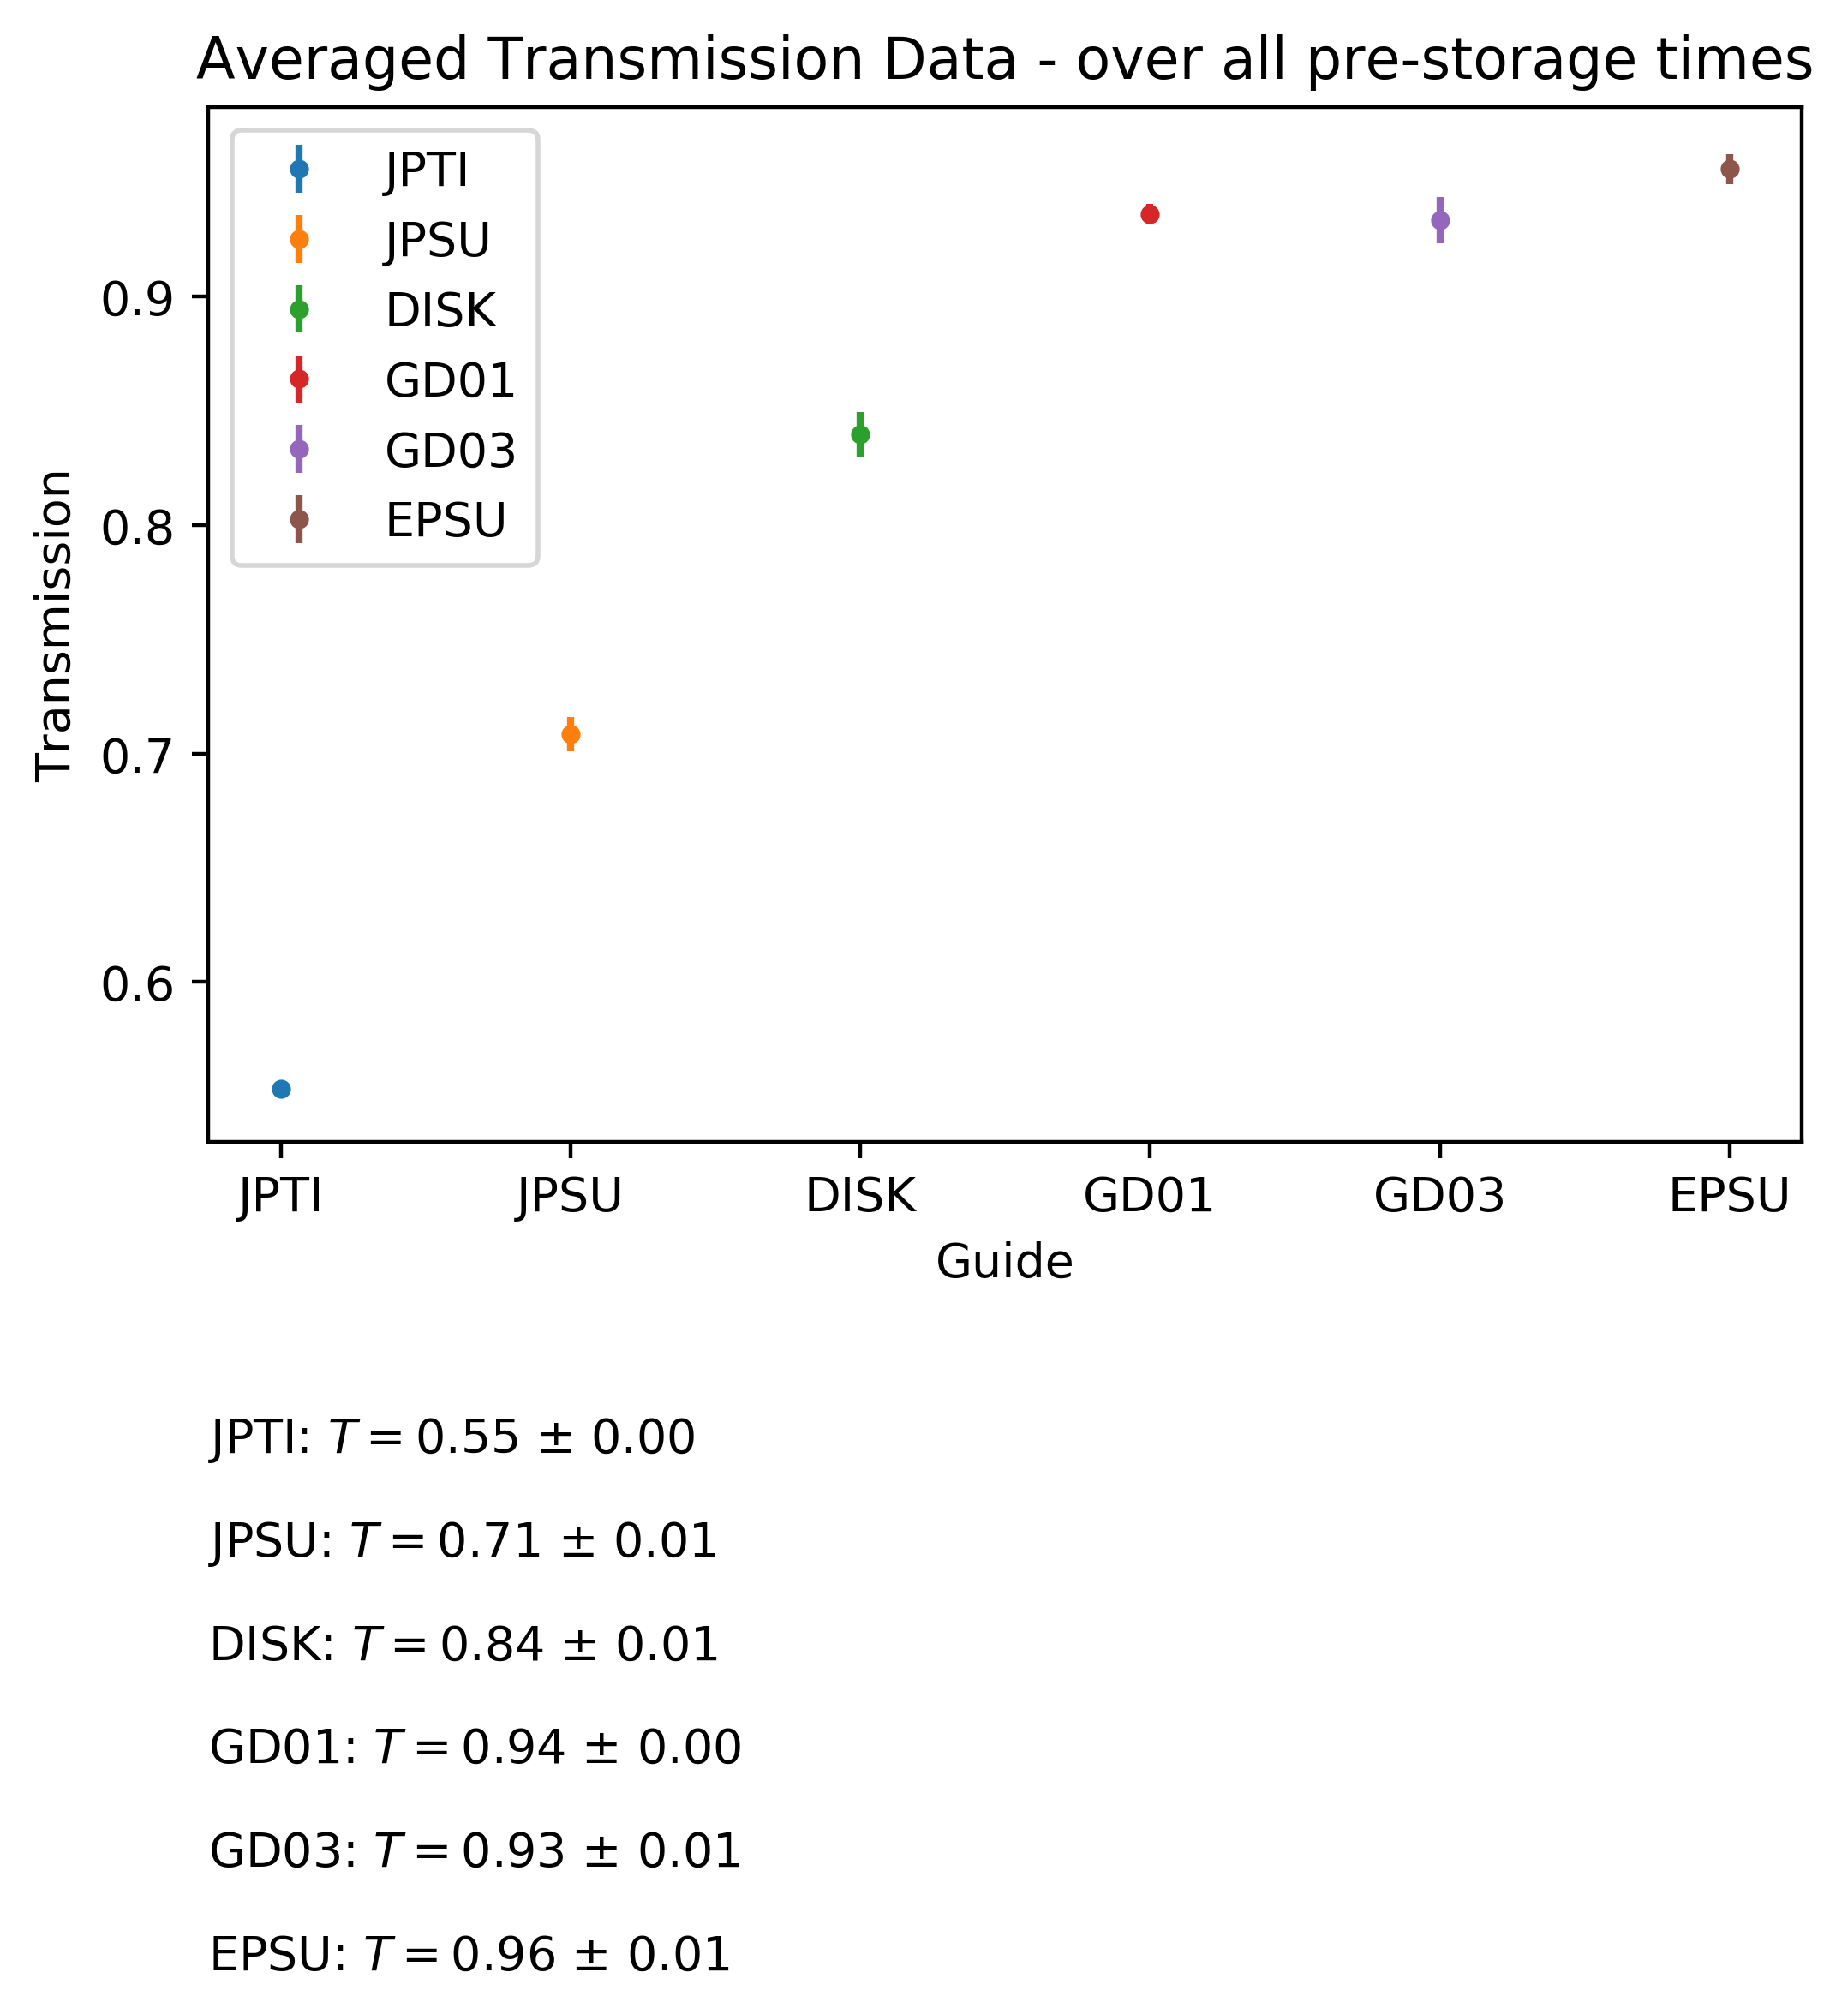

In [42]:
config_list = ['JPTI', 'JPSU', 'DISK', 'GD01', 'GD03', 'EPSU']

# we do not work with the shot measurements here, as they are not storage type measurements.
run_type_list = ['s005', 's020', 's100']

# working with a copy to avoid any overwriting
all_data_dict = dict(main_data_dict)
N_nom_dict_copy = dict(N_nom_dict)

# making a new dictionary of transmission results
t_dict = {}

fig, ax = plt.subplots()
ax = plt.gca()

# for counting loop iterations
text_y_coord = -0.2

# generating a plot where we average the transmission results for all 
# runs in a single configuration and storage time.
fig_ave, ax_ave = plt.subplots()

# generating a third plot where we average the transmission results 
# for all runs in a single configuration and storage time
fig_all_ave, ax_all_ave = plt.subplots()

for config in config_list:
    
    # update the plotting color
    color = next(ax._get_lines.prop_cycler)['color']
    
    arr_all_ave = np.empty((0,2), float)
    
    for run_type in run_type_list:
        
        # an array to hold the results, to then average
        arr_ave = np.empty((0,2), float)
        
        arr = all_data_dict[config, run_type]
        
        # iterate over each individual measurement
        for i in range(0, np.shape(arr)[0]):

            T = arr[i,2] / N_nom_dict_copy[run_type, 'N']

            T_frac_err = np.sqrt((arr[i,3] / 
                                  arr[i,2])**2 + 
                                 (N_nom_dict_copy[run_type, 'N_err'] / 
                                  N_nom_dict_copy[run_type, 'N'])**2) 

            T_err = T * T_frac_err

            if (i == 0 and run_type == 's005'):

                ax.errorbar(arr[i,1], T, yerr = T_err, fmt = '.',
                         label = config, color = color)

            else:

                ax.errorbar(arr[i,1], T, yerr = T_err, fmt = '.',
                         color = color)
                
            # add the results to arr_ave array
            arr_ave = np.append(arr_ave, [[T, T_err]], axis = 0)
            
            # add the results to arr_all_ave array
            arr_all_ave = np.append(arr_all_ave, [[T, T_err]], axis = 0)
            
        # calculate the average
        T_ave = np.average(arr_ave[:,0])
        
        # propagate the error through to the average
        T_ave_err = (1 / np.shape(arr_ave)[0]) * np.sqrt(np.sum(arr_ave[:,1]**2))            
                
        # add the results to dictionary
        t_dict[config, run_type, 'T']     =  T_ave
        t_dict[config, run_type, 'T_err'] =  T_ave_err
        
        if (run_type == 's005'):
            
            ax_ave.errorbar(float(run_type[1:4]), T_ave, T_ave_err, 
                            fmt = '.', label = config, color = color)
            
        else:
            
            ax_ave.errorbar(float(run_type[1:4]), T_ave, T_ave_err, 
                fmt = '.', color = color)
        
    # !!! loop this over storage time. 
    # printing the fit results below the figure
    text_y_coord = text_y_coord - 0.1
    ax_ave.text(0, text_y_coord, 
                    config 
                    + r': $T_5 = $%.2f $\pm $ %.2f$, \quad T_{20} = $%.2f $ \pm $ %.2f$, \quad T_{100} = $%.2f $ \pm $ %.2f' % 
                (
                t_dict[config, 's005', 'T'], 
                t_dict[config, 's005', 'T_err'],
                t_dict[config, 's020', 'T'],
                t_dict[config, 's020', 'T_err'],
                t_dict[config, 's100', 'T'],
                t_dict[config, 's100', 'T_err']
                ),
                transform = ax_ave.transAxes);
    
    # here we are outside the run_type loop and can copmpute an average transmission over all storage times
    T_ave = np.average(arr_all_ave[:,0])
    T_ave_err = (1 / np.shape(arr_all_ave)[0]) * np.sqrt(np.sum(arr_all_ave[:,1]**2))     
    print(config + ': {}'.format(np.std(arr_all_ave[:,0])))
    # add the results to dictionary
    t_dict[config, 'all', 'T']     =  T_ave
    t_dict[config, 'all', 'T_err'] =  T_ave_err

    # plot
    ax_all_ave.errorbar([config], T_ave, T_ave_err, 
                        fmt = '.', label = config, color = color)
    
    # !!! loop this over storage time. 
    # printing the fit results below the figure
#     text_y_coord = text_y_coord - 0.1
    ax_all_ave.text(0, text_y_coord, 
                    config 
                    + r': $T = $%.2f $\pm $ %.2f' % 
                (
                T_ave, T_ave_err
                ),
                transform = ax_all_ave.transAxes);

                    
# presentation stuff
ax.set_title('Transmission - All Guided Runs')
ax.set_ylabel('Transmission');
ax.set_xlabel('Pre-Storage Time (s)')
ax.legend();
# ax.set_yscale('log')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax_ave.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax_ave.set_ylabel('Transmission');
ax_ave.set_xlabel('Pre-Storage Time (s)')
ax_ave.set_title('Averaged Transmission Data')
ax_ave.legend();

ax_all_ave.set_ylabel('Transmission');
ax_all_ave.set_xlabel('Guide')
ax_all_ave.set_title('Averaged Transmission Data - over all pre-storage times')
ax_all_ave.legend();